<a href="https://colab.research.google.com/github/lleviraz/urban_segmentation/blob/main/notebooks/S2_and_ESM_EDA_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA and Preprocessing of the Sentinel2 (S2) and European Settlement Map (ESM) for Segmentation Tasks

This notebook contains an exploratory data analysis `(EDA)` and dataset `preprocessing` of the Sentinel2 (S2) and European Settlement Map (ESM), for the purpose of Segmentation of build up areas to residential and non residentials.


By: Eli T. and Liad.L.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# !pip install rasterio fastai -q
!pip install fastai wwf nbdev rasterio geopandas fastbook tiffile imagecodecs pytorch-ignite -q

     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 
     |████████████████████████████████| 1.0 MB 45.0 MB/s 
     |████████████████████████████████| 720 kB 49.4 MB/s 
     |████████████████████████████████| 31.0 MB 1.5 MB/s 
     |████████████████████████████████| 251 kB 22.5 MB/s 
     |████████████████████████████████| 431 kB 55.1 MB/s 
     |████████████████████████████████| 60 kB 5.9 MB/s 
     |████████████████████████████████| 188 kB 57.5 MB/s 
     |████████████████████████████████| 561 kB 45.6 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 133 kB 57.1 MB/s 
     |████████████████████████████████| 130 kB 63.6 MB/s 
     |████████████████████████████████| 428 kB 57.5 MB/s 
     |████████████████████████████████| 6.3 MB 31.0 MB/s 
     |████████████████████████████████| 16.7 MB 28.9 MB/s 
     |████████████████████████████████| 1.2 MB 47.4 MB/s 
ERROR: pip's depend

In [ ]:
# Connect to Drive
import os
import sys
import glob
import numpy as np
import pprint as pp
import pandas as pd
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#fastai
from fastai.torch_core import tensor
from fastai.basics import *


import rasterio as rio
from rasterio.transform import Affine
from rasterio.plot import show_hist,show
from rasterio.warp import calculate_default_transform, reproject, Resampling


# Dataset EDA

The dataset consists of 700 Satelite images images

S2 directory
------------
S2 is composed of Sentinel-2 images, exported with the follwowing 11 bands and represents mean values for the years 2017-2020 (from https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR)

- B1:  Blue
- B2:  Green
- B3:  Red
- B4:  Red Edge 1
- B5:  Red Edge 2
- B6:  Red Edge 3
- B7:  Near-Infrared (NIR)
- B8:  Red Edge 4
- B9:  Water vapor
- B10: Shortwave Infrared 1 (SWIR 1)
- B11: Shortwave Infrared 2 (SWIR 2)

Note: for displaying in RGB use a range between 0 and 0.3 for the red, green, and blue channels.

ESM directory
-------------
Contains the "Masks" which show the distinction between residential and non-residential areas (250 for non-residential and 255 for residential, 1 for all other areas, and 0 for "no data")

The original S2 and ESM raster types are not aligned in terms of spatial extent and resolution, therefore an alignment (projection) is done in this notebook to align the image Coordinates systems and  dimentsions

In [ ]:
# Create a path to the exported folder where the ESM and S2 directories were extracted to
os.chdir('/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks')
EXPORT_DIR='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset'
sys.path.append('/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks')

#our modules
from libs.preprocess import *

path = Path(EXPORT_DIR)
[f for f in path.iterdir()]

[Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM'),
 Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2'),
 Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM.zip'),
 Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_11b'),
 Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized'),
 Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned'),
 Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test'),
 Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned_test')]

In [ ]:
ESM_DIR = EXPORT_DIR + '/ESM'
S2_DIR = EXPORT_DIR + '/S2'

esm_path = Path(ESM_DIR)
s2_path = Path(S2_DIR)

#next(s2_path.iterdir()) 
SAMPLE_IMAGE = Path(os.path.join(s2_path,'R_4_337.tif'))
#next(esm_path.iterdir())
SAMPLE_MASK = Path(os.path.join(esm_path,'ESM_337.tif'))
SAMPLE_IMAGE,SAMPLE_MASK

(Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_4_337.tif'),
 Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_337.tif'))

In [ ]:
print('Number of input images:',len(glob.glob(S2_DIR + '/*.tif')))

Number of input images: 700


## Reading MultiChannel images (using Rasterio)

Unlike the common RGB images with 3 channels Red,Green and Blue, S2 images have multi channels (bands), in our case they were exported with 11 bands (with values are between 0 and 0.3)


In [ ]:
def normalize(image,vmin=0.0,vmax=0.3):
  '''
  RGB data was exported in the range between 0 and 0.3
  '''
  return (image - vmin)/(vmax-vmin)

def display_image(image_path,bands=[3,2,1],title=None,ax=None):
  '''
  Displaying RBG images by Red,Green,Blue in this order
  '''
  img =  rio.open(image_path)
  show(normalize(img.read(bands)), title=title,ax=ax)
  # print(title,len(img.indexes),'bands')
  return img

## Sample image and matching mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


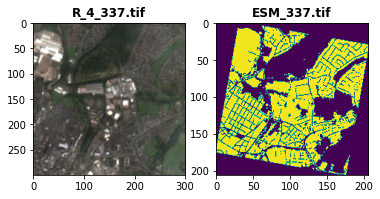

In [ ]:
f,ax = plt.subplots(1,2)
s2_sample = display_image(SAMPLE_IMAGE,title=SAMPLE_IMAGE.name,ax=ax[0])
esm_sample = display_image(SAMPLE_MASK,bands=[1],title=SAMPLE_MASK.name,ax=ax[1])

ESM is the distinction between residential and non-residential areas (a "MASK"), here are the classes:

- 250 for non-residential
- 255 for residential
- 1 for all other areas
- 0 for no data

In [ ]:
def print_mask_stats(rasterio_img,title=None):
  '''
  Prints statistics about a mask classes
  '''
  classes,counts = np.unique(rasterio_img.read(1),return_counts=True)
  print(title + ' classes:',classes)
  sumc = sum(counts)
  pp.pprint(['class:{},count:{},{:.2f}%:'.format(classes[i],c*100,c*100/sumc) for i,c in enumerate(counts)])
  print(len(rasterio_img.indexes),' bands')

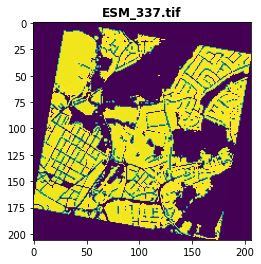

ESM_337.tif classes: [  0   1 250 255]
['class:0,count:1047300,24.68%:',
 'class:1,count:1261200,29.72%:',
 'class:250,count:801600,18.89%:',
 'class:255,count:1133500,26.71%:']
1  bands


In [ ]:
display_image(SAMPLE_MASK,bands=[1],title=SAMPLE_MASK.name)
print_mask_stats(esm_sample,title=SAMPLE_MASK.name)

## Files metadata

ESM and S2 have a different spatial transform and resolution:

- `ESM` is `1x203x203`
- `S2` is `11x301x301`

In [ ]:
# def print_image_metadata(rasterio_img,title=None):
#   print(title + ' Metadata:',rasterio_img.meta)
#   print(title + ' Transform:\n',rasterio_img.transform)

In [ ]:
print_image_metadata(esm_sample,SAMPLE_MASK.name)

ESM_337.tif Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 206, 'height': 206, 'count': 1, 'crs': CRS.from_epsg(3035), 'transform': Affine(10.0, 0.0, 3479760.0,
       0.0, -10.0, 3447380.0)}
ESM_337.tif Transform:
 | 10.00, 0.00, 3479760.00|
| 0.00,-10.00, 3447380.00|
| 0.00, 0.00, 1.00|


In [ ]:
print_image_metadata(s2_sample,SAMPLE_IMAGE.name)

R_4_337.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, -304700.0,
       0.0, -10.0, 7069853.136509213)}
R_4_337.tif Transform:
 | 10.00, 0.00,-304700.00|
| 0.00,-10.00, 7069853.14|
| 0.00, 0.00, 1.00|


## RGB bands

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


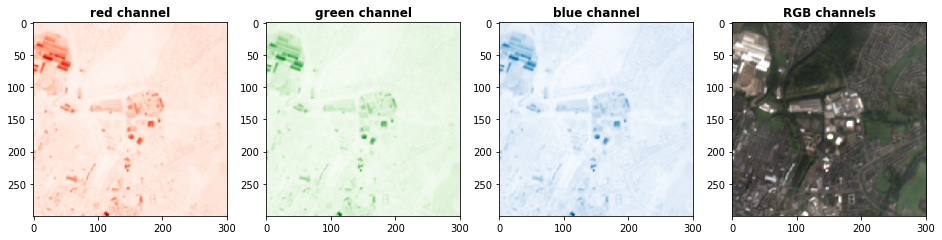

In [ ]:
#Using rasterio - normalize RGB channels between 0 and 0.3 (the way they were extracted)
fig, (axr, axg, axb,axrgb) = plt.subplots(1,4, figsize=(16,5))
show(normalize(s2_sample.read(1)), ax=axr, cmap='Reds', title='red channel')
show(normalize(s2_sample.read(2)), ax=axg, cmap='Greens', title='green channel')
show(normalize(s2_sample.read(3)), ax=axb, cmap='Blues', title='blue channel')
show(normalize(s2_sample.read([3,2,1])), ax=axrgb, title='RGB channels')

## Plots of the different bands in a sample S2 image

|B1|B2|B3|B4|B5|B6|B7|B8|B9|B10|B11|
|-----|-------|--------|-----|-------|--------|-----|-------|--------|-----|-------|
|Blue|Green|Red|Red Edge 1|Red Edge 2|Red Edge 3|Near-Infrared|Red Edge 4|Water vapor|Shortwave IR 1|Shortwave IR 2|

In [ ]:
NUM_BANDS = 15

bands_dictionary = {
    1:'B1_Blue',
    2:'B2_Green',
    3:'B3_Red',
    4:'B4_Red_Edge_1',
    5:'B5_Red_Edge_2',
    6:'B6_Red_Edge_3',
    7:'B7_NIR',
    8:'B8_Red_Edge_4',
    9:'B9_Water_vapor',
    10:'B10_SWIR_1',
    11:'B11_SWIR_2',
    12:'B12_NDVI', #added in this NB
    13:'B13_NDTI', #added in this NB
    14:'B14_NDVIre', #added in this NB
    15:'B15_MNDWI' #added in this NB
}

In [ ]:
# cms = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet',]
cms = ['icefire']

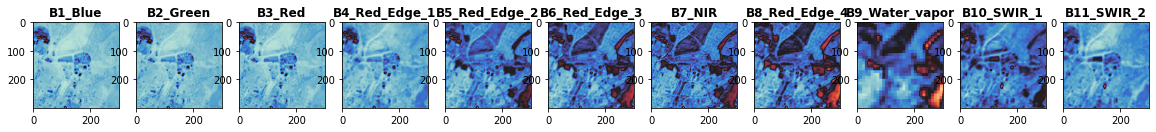

In [ ]:
for cm in cms:
  f, axes = plt.subplots(1,s2_sample.count,figsize=(20,4))
  for i in range(1,s2_sample.count+1):
    # show(normalize(s2_sample.read(i)), ax=axes[i-1], title=bands_dictionary[i],cmap=cm)
    show(s2_sample.read(i), ax=axes[i-1], title=bands_dictionary[i],cmap=cm)
    # plt.suptitle(cm)
  plt.show()
  # show(esm_sample.read(1), ax=axes[1,i-1], title='Mask',cmap=cm)

## Images colors histrograms and mask classes

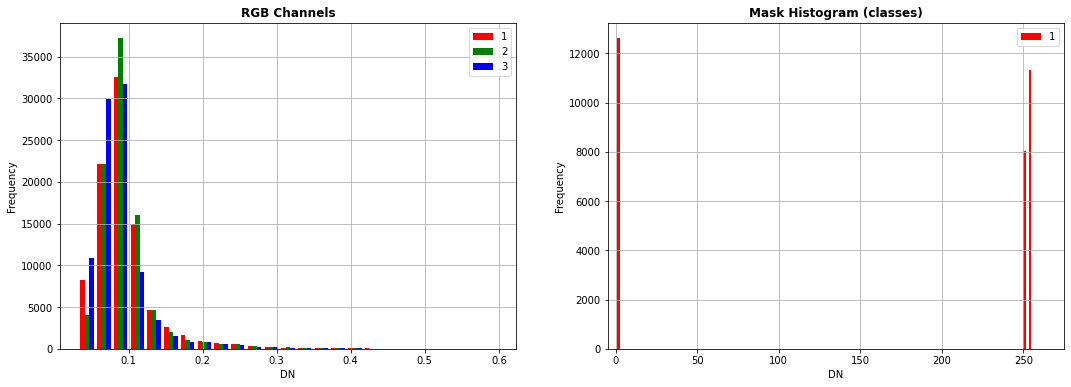

In [ ]:
fig, (axh1, axh2) = plt.subplots(1,2, figsize=(18,6))
show_hist(s2_sample.read([3,2,1]), ax=axh1,bins=25, histtype='bar',title="RGB Channels")
axh2.set_xlim(-5, 275)
show_hist(esm_sample, ax=axh2,bins=150,  title="Mask Histogram (classes)")


# Preprocessing

1. Resize all multi channel S2 images to (11,300,300) - some of the images are with different dimensions
2. Align each mask to the S2 images Coordinate System (CRS) from CRS ESPG_3035 to ESPG_3857

## Reprojection using Rasterio

In [ ]:
#RENAME FILES WITH SPACE IN NAME
def rename_images():
  s2_files = glob.glob(S2_DIR + '/*.tif')
  for path in tqdm(s2_files):
      newname =  path.replace(' ', '_')
      # print(newname,path)
      if newname != path:
          os.rename(path,newname)

#UNCOMMENT to rename
# rename_images()

In [ ]:
#Target folders
esm_aligned = os.path.join(EXPORT_DIR ,'esm_aligned/')
s2_resized = os.path.join(EXPORT_DIR,'s2_resized/')

## Resizing input images to have the same dimensions (300x300) + Adding new Bands Combinations

Simple Torch Resize in DataLoaders do not to work with the Multi bands images , only with images of 3 channels...

Adding new band to src images (inspired by Yoav, and [this paper](https://www.researchgate.net/publication/330994618_Separating_Built-Up_Areas_from_Bare_Land_in_Mediterranean_Cities_Using_Sentinel-2A_Imagery))

(Note: B1 is Red , in the original S2 B2 is Red)


1. NDVI : Normalized difference vegetation index - Added as **B12**

$NIR-RED \over NIR+RED$=$B7-B3 \over B7+B3$

2. NDTI:Normalized Difference Tillage Index  - Added as **B13**

$(SWIR 1 - SWIR 2) \over (SWIR 1 + SWIR 2)$ = $(B10-B11) \over (B10+B11)$

3. NDVIre: Normalized Difference Vegetation Index  - Added as **B14**

$((RedEdge 1 - Red)) \over ((RedEdge 1 + Red))$ = $((B4 - B3)) \over ((B4 + B3))$

4. MNDWI: Modified Normalized Difference Water Index  - Added as **B15**

$ ((Green - SWIR 1))\over((Green + SWIR 1))$ = $ ((B2 - B10))\over((B2 + B10))$


<br>

We don't have Band 21 but if we did we could create:

NBDI : Normalized Difference Bare ice Index

$(B2-B21) \over (02+B21)$

In [ ]:
#UNCOMMENT if you want to regenerate all images
# !rm -rf /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned
# !rm -rf /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized

In [ ]:
def get_ndvi(img):
  '''
  NDVI : Normalized difference vegetation index - Added as **B12**
  (B7-B3)/(B7+B3)
  '''
  B7 = img.read(7)
  B3 = img.read(3)
  NDVI = (B7-B3)/(B7+B3)
  return np.expand_dims(NDVI, axis=0)

In [ ]:
def get_ndti(img):
  '''
  NDTI:Normalized Difference Tillage Index  - Added as **B13**
  (B10-B11)/(B10+B11)
  '''
  B10 = img.read(10)
  B11 = img.read(11)
  NDTI = (B10-B11)/(B10+B11)
  return np.expand_dims(NDTI, axis=0)

In [ ]:
def get_ndvire(img):
  '''
  NDVIre: Normalized Difference Vegetation Index  - Added as **B14**
  ((B4 - B3)) / ((B4 + B3))
  '''
  B4 = img.read(4)
  B3 = img.read(3)
  NDVIre = (B4-B3)/(B4+B3)
  return np.expand_dims(NDVIre, axis=0)

In [ ]:
def get_mndwi(img):
  '''
  MNDWI: Modified Normalized Difference Water Index  - Added as **B15**
  ((B2 - B10)) / ((B2 + B10))
  '''
  B2 = img.read(2)
  B10 = img.read(10)
  MNDWI = (B2-B10)/(B2+B10)
  return np.expand_dims(MNDWI, axis=0)

In [ ]:
def batch_resize(src_dir,target_dir,rsmpl=Resampling.nearest):
  '''
  Lazy batch resize multi band TIF images  band into (300,300) + adding NDVI band
  '''
  with rio.Env():
    print('Source dir:',src_dir)
    print('Target dir:',target_dir)

    if(os.path.isdir(target_dir)):
      print('{} Directory exists, exiting(DELETE it and rerun to force regeneration)'.format(target_dir))
      target = os.listdir(target_dir)
      number_files = len(target)
      print(number_files)
      return

    print('Creating ',target_dir )
    os.makedirs(target_dir)
    
    # target_size = (12,256,256)
    target_size = (NUM_BANDS,300,300)
    src_files = glob.glob(src_dir + '/*.tif')
    print(len(src_files),'images to resize + additional 4 band to ',target_size)

    for src_file in tqdm(src_files):
        fname = Path(src_file).name

        with rio.open(os.path.join(src_dir,fname)) as src:
          rows, cols = src_shape = src.shape
          src_transform = src.transform
          src_crs = src.crs
          source = src.read()
          #adding NDVI band
          ndvi = get_ndvi(src)
          source = np.concatenate((source,ndvi),axis=0)
          #adding NDVI band
          ndti = get_ndti(src)
          source = np.concatenate((source,ndti),axis=0)
          #adding NDVI band
          ndvire = get_ndvire(src)
          source = np.concatenate((source,ndvire),axis=0)
          #adding NDVI band
          mndwi = get_mndwi(src)
          source = np.concatenate((source,mndwi),axis=0)

          dst_shape = target_size
          dst_transform = src.transform
          dst_crs = src.crs 
          destination = np.zeros(dst_shape, src.dtypes[0])
          
          reproject(
            source,
            destination,
            dst_width=target_size[1],
            dst_height=target_size[2],
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=rsmpl)

          # Write it out to a file.
          with rio.open(
                  os.path.join(target_dir,fname),'w',
                  driver='GTiff',
                  width=dst_shape[1],
                  height=dst_shape[2],
                  count=NUM_BANDS,#src.count+1,
                  dtype=src.dtypes[0],
                  nodata=None,
                  transform=dst_transform,
                  crs=dst_crs) as dst:
                      dst.write(destination, indexes=range(1,NUM_BANDS+1))


In [ ]:
batch_resize(S2_DIR,s2_resized)


Source dir: /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2
Target dir: /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/ Directory exists, exiting(DELETE it and rerun to force regeneration)
650


## Batch transforms ESM MASKs with 1 band into the the Sentinel2 image CRS


In [ ]:
'''
Lazy batch transform of ESM MASKs with 1 band into the the Sentinel2 image CRS
'''

def get_matching_img_path(fname,src_img_dir=S2_DIR):
    '''
    Return the matching image for a given mask
    '''
    suffix = fname.split('_')
    img_file = glob.glob(src_img_dir + '/*'+suffix[-1])
    return img_file[0]

def batch_projection(src_dir,target_dir,orig_img_dir,rsmpl=Resampling.nearest):
  with rio.Env():
    print('Source dir:',src_dir)
    print('Target dir:',target_dir)
    print('Orig images dir:',orig_img_dir)

    if(os.path.isdir(target_dir)):
      print('{} Directory exists, exiting(DELETE it and rerun)'.format(target_dir))
      target = os.listdir(target_dir)
      number_files = len(target)
      print(number_files)
      return

    print('Creating ',target_dir )
    os.makedirs(target_dir)

    # dst_crs = 'EPSG:3857'
    src_files = glob.glob(src_dir + '/*.tif')
    print(len(src_files),'images to transform')

    for src_file in tqdm(src_files):
      fname = Path(src_file).name

      with rio.open(get_matching_img_path(fname,orig_img_dir)) as matching_image:
        
        with rio.open(os.path.join(src_dir,fname)) as src:
          rows, cols = src_shape = src.shape
          src_transform = src.transform
          src_crs = src.crs

          # print(src,rows,cols,src_transform,src_crs)
          source = src.read(1)

          dst_shape = matching_image.shape
          dst_transform = matching_image.transform
          dst_crs = matching_image.crs 
          destination = np.zeros(dst_shape, np.uint8)
          
          reproject(
          source,
          destination,
          src_transform=src_transform,
          src_crs=src_crs,
          #  nodata=0,
          dst_transform=dst_transform,
          dst_crs=dst_crs,
          resampling=rsmpl)

          # Write it out to a file.
          with rio.open(
                  os.path.join(target_dir,fname),
                  'w',
                  driver='GTiff',
                  width=dst_shape[1],
                  height=dst_shape[0],
                  count=1,
                  dtype=np.uint8,
                  nodata=0,
                  transform=dst_transform,
                  crs=dst_crs) as dst:
              dst.write(destination, indexes=1)


In [ ]:
batch_projection(ESM_DIR,esm_aligned,s2_resized)

Source dir: /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM
Target dir: /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/
Orig images dir: /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ Directory exists, exiting(DELETE it and rerun)
650


## Validate that the generated masks and plot some samples of the transformed MASKs with original and matching image

Note: the class proprtions are saved, except for the **'no-data'** class (0) at the margins (white triangle areas), which are minimized due to the alignment (rotation).

In [ ]:
cols = ['0','1','250','255']
df_orig_mask_class_counts = pd.DataFrame(columns=cols)
df_new_mask_class_counts = pd.DataFrame(columns=cols)

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


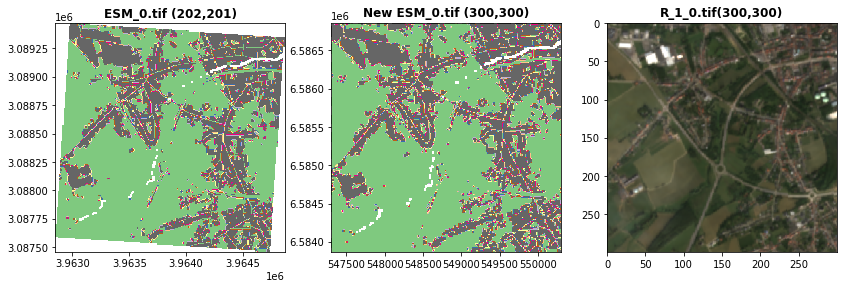

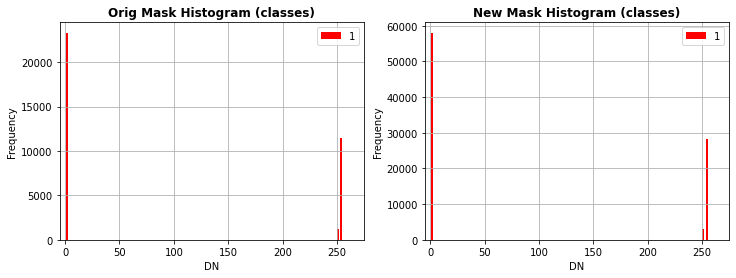

/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_0.tif classes: [  0   1 250 255]
['class:0,count:472700,11.64%:',
 'class:1,count:2330400,57.40%:',
 'class:250,count:117000,2.88%:',
 'class:255,count:1140100,28.08%:']
1  bands
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_0.tif classes: [  0   1 250 255]
['class:0,count:73100,0.81%:',
 'class:1,count:5802800,64.48%:',
 'class:250,count:289700,3.22%:',
 'class:255,count:2834400,31.49%:']
1  bands


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


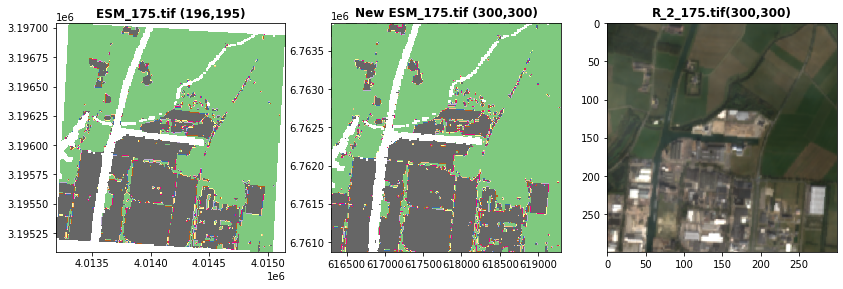

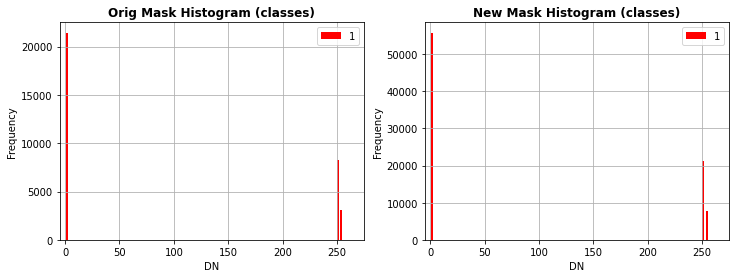

/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_175.tif classes: [  0   1 250 255]
['class:0,count:546900,14.31%:',
 'class:1,count:2144100,56.10%:',
 'class:250,count:824200,21.56%:',
 'class:255,count:306800,8.03%:']
1  bands
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_175.tif classes: [  0   1 250 255]
['class:0,count:502900,5.59%:',
 'class:1,count:5580100,62.00%:',
 'class:250,count:2128700,23.65%:',
 'class:255,count:788300,8.76%:']
1  bands


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


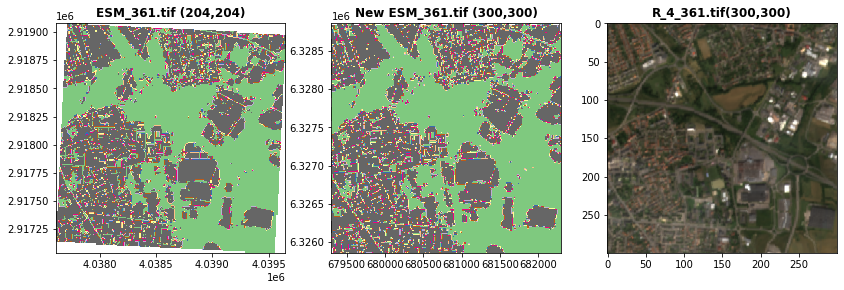

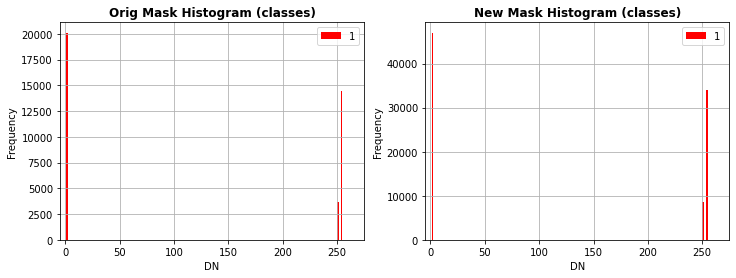

/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_361.tif classes: [  0   1 250 255]
['class:0,count:334600,8.04%:',
 'class:1,count:2011200,48.33%:',
 'class:250,count:367300,8.83%:',
 'class:255,count:1448500,34.81%:']
1  bands
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_361.tif classes: [  0   1 250 255]
['class:0,count:45800,0.51%:',
 'class:1,count:4700500,52.23%:',
 'class:250,count:859100,9.55%:',
 'class:255,count:3394600,37.72%:']
1  bands


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


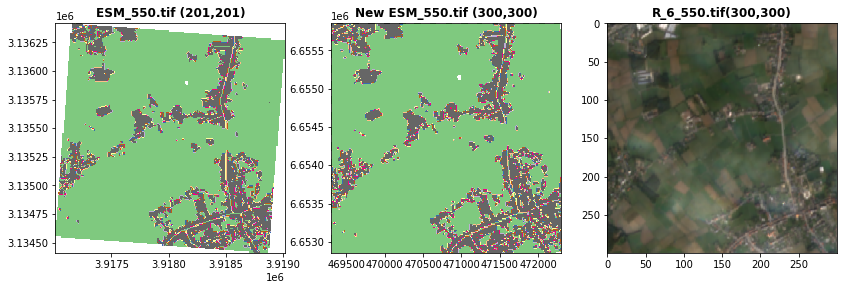

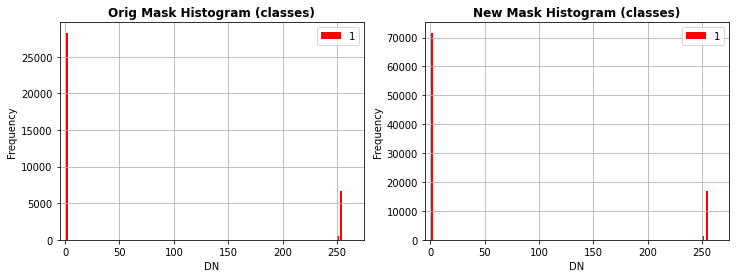

/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_550.tif classes: [  0   1 250 255]
['class:0,count:501100,12.40%:',
 'class:1,count:2827600,69.99%:',
 'class:250,count:46400,1.15%:',
 'class:255,count:665000,16.46%:']
1  bands
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_550.tif classes: [  0   1 250 255]
['class:0,count:30000,0.33%:',
 'class:1,count:7168900,79.65%:',
 'class:250,count:120400,1.34%:',
 'class:255,count:1680700,18.67%:']
1  bands


In [ ]:
#run dataset validation
orig_mask,new_mask,orig_img = None,None,None
orig_mask,new_mask,orig_img = validate_dataset(s2_resized,esm_aligned,
                                               ESM_DIR,df_orig_mask_class_counts,
                                               df_new_mask_class_counts)

In [ ]:
from fastai.torch_core import TensorBase

In [ ]:
if (new_mask != None):
  print('---------------------------------')
  print(orig_mask.name,'\n',orig_mask.meta)
  print('---------------------------------')
  print(new_mask.name,'\n',new_mask.meta)
  print('---------------------------------')
  print(orig_img.name,'\n',orig_img.meta)
  print('---------------------------------') 

---------------------------------
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_686.tif 
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 205, 'height': 205, 'count': 1, 'crs': CRS.from_epsg(3035), 'transform': Affine(10.0, 0.0, 3720930.0,
       0.0, -10.0, 3240350.0)}
---------------------------------
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_686.tif 
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 300, 'height': 300, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 139300.0,
       0.0, -10.0, 6790866.696607751)}
---------------------------------
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_7_686.tif 
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 15, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 139300.0,
       0.0, -10.0, 6790866.696607751)}
---------------------------------


In [ ]:
B8 = s2_sample.read(8)
B4 = s2_sample.read(4)
NDVI = (B8-B4)/(B8+B4)
NDVI.shape

(300, 301)

## Validate the the class proportions were kept after the transformation

 (except for class 0 no_data which was minimized due to the rotation)

<img src='images/mask_class_proprtions.png'/>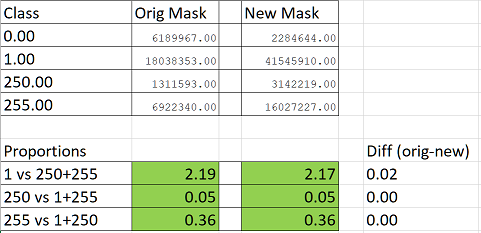

In [ ]:
classes = ['0','1','250','255']
om=get_bu_area_ratio(df_orig_mask_class_counts,cols = classes)
nm=get_bu_area_ratio(df_new_mask_class_counts,cols = classes)

### Ratio of BU area comparison (without "no data" class)

We can see that due to the "no_data" shrinking, and the resize to 300x300 , the new distribution sum is larger, and it is a little shifted to the right compared to the original masks, but when taking out the no_data the distributions of before and after are very very close.

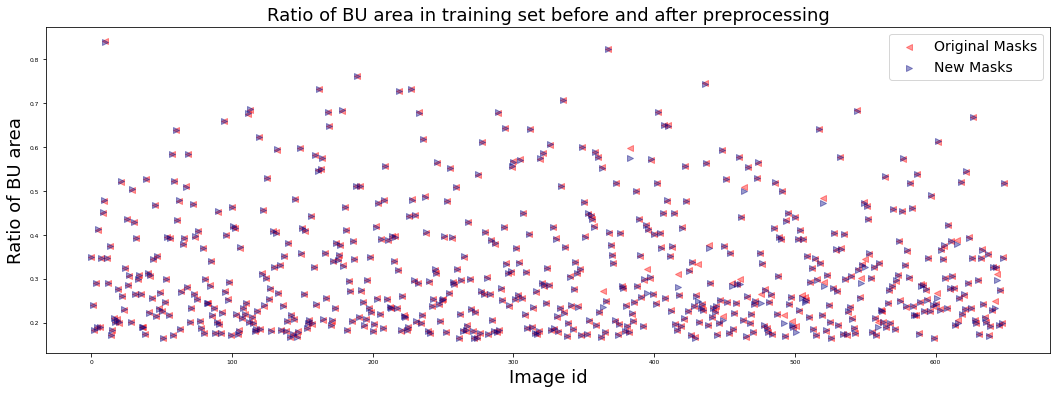

In [ ]:
#TODO move to libs - merge with  def plot_scatter_diff(...)
f,ax1 = plt.subplots(1,1,figsize=(18,6))
x1=om.index
y1=om
ax1.scatter(x1,y1,alpha=0.4,marker='<',color='red')

x2=nm.index
y2=nm
ax1.scatter(x2,y2,alpha=0.4,marker='>',color='navy')
ax1.set_xlabel('Image id',fontsize=18)
ax1.set_ylabel('Ratio of BU area',fontsize=18)
ax1.set_title('Ratio of BU area in training set before and after preprocessing',fontsize=18)
plt.legend({'Original Masks','New Masks'},fontsize=14)
plt.show()


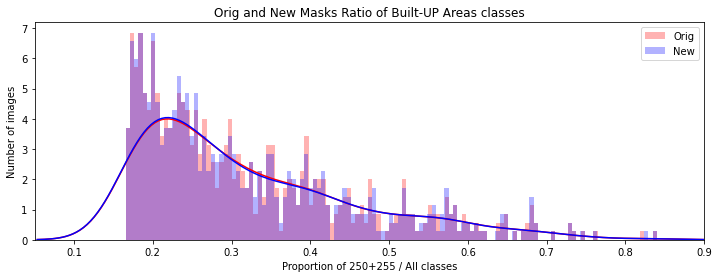

In [ ]:
f,ax1 = plt.subplots(1,1,figsize=(12,4))

plot_hist(om,'',ax1,'Red',lbl='Orig')
plot_hist(nm,'Orig and New Masks Ratio of Built-UP Areas classes',ax1,'blue',lbl='New')
plt.show()


In [ ]:
om.min(),om.max(),om.mean(),om.sum()

(0.16571978815599422,
 0.8404208680403332,
 0.3216984074572876,
 209.10396484723697)

In [ ]:
nm.min(),nm.max(),nm.mean(),nm.sum()

(0.16555294012650743, 0.8399057609244405, 0.32108030000966, 208.702195006279)

In [ ]:
nm.to_csv('orig_masks_bu_area.csv',header=False)

In [ ]:
get_bu_area_ratio(df_new_mask_class_counts,with_no_data=True,cols=classes).to_csv('orig_masks_bu_area_w_nodata.csv',header=False)

## Masks - Display Classes Imbalance

We can see that (as expected) there is a class imbalance.

- Class 1 - "Land / Other" is the most popular with 66%
- Class 255 - 'Residential' around 25%
- Class 250 - 'Non Residential' around 5%
- Class 0 - 'no data' - 4%

We need to deal with that in the Segmentation task by using:
1. Select a proper loss function (insensitive to the imbalance)
2. Augmentations + Upsampling of the lower classes

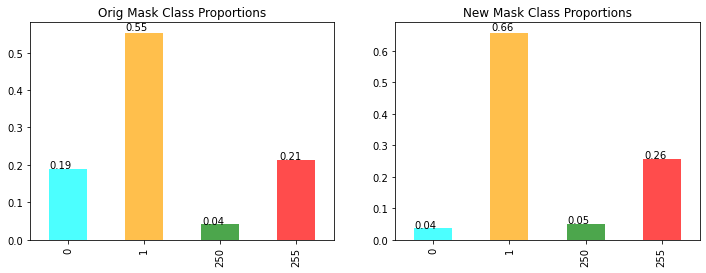

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

 
plot_bar(df_orig_mask_class_counts,'Orig Mask Class Proportions',ax1)
plot_bar(df_new_mask_class_counts,'New Mask Class Proportions',ax2)

for a in [ax1,ax2]:
  annotate(a)

plt.show()

In [ ]:
df_new_mask_class_counts.to_csv('df_orig_mask_class_counts.csv',header=False)


# Generate the dataset statistics for later normalization during training

In [ ]:
stats_mean_df = pd.DataFrame(columns=range(1,NUM_BANDS))
stats_std_df = pd.DataFrame(columns=range(1,NUM_BANDS))
s2_images = glob.glob(s2_resized+ '/*.tif')
for row,image in tqdm(enumerate(s2_images)):
  with rio.open(image,'r') as im:
    for c in range(1,im.count+1):
      chn=np.array(im.read(c))
      stats_mean_df.loc[row,c] = chn.mean()
      stats_std_df.loc[row,c] = chn.std()
       
stats_mean_df.head(3)

0it [00:00, ?it/s]

1         2         3         4         5         6         7   \
0  0.066742  0.088533  0.086858  0.127303  0.225129  0.259477  0.273611   
1  0.093488  0.118419  0.123021  0.163532  0.241001  0.270571  0.275663   
2  0.081833  0.110869   0.12025  0.163313  0.236564  0.262302  0.272449   

         8         9         10        11        12        13        14  \
0  0.277847  0.286784  0.200476  0.144928  0.504103  0.166276  0.207407   
1  0.285874  0.298707  0.246779  0.186028  0.370415  0.145956  0.149912   
2  0.282418  0.287662   0.26923  0.196165   0.39161  0.162746  0.166089   

         15  
0 -0.395588  
1 -0.343805  
2 -0.423616

In [ ]:
# x_max = stats_std_df.max()

In [ ]:
# stats_mean_df

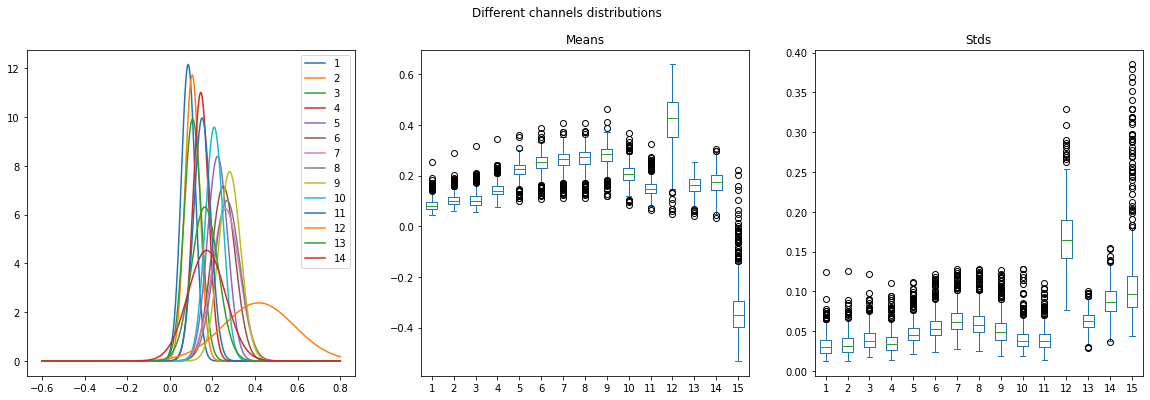

In [ ]:
f,axs = plt.subplots(1,3,figsize=(20,6))
x = np.arange(-0.6, 0.8, 1e-04)
for i in range(1,NUM_BANDS):
  #Filter some bands
  # if i in [11,12,13,14,15,16]:
  axs[0].plot(x, scipy.stats.norm.pdf(x, stats_mean_df.mean()[i], stats_std_df.mean()[i]),label=i)
    

stats_mean_df.plot.box(ax=axs[1])
# stats_mean_df[[12,13,14,15]].plot.box(ax=axs[1])
axs[1].set_title('Means')
stats_std_df.plot.box(ax=axs[2])
# stats_std_df[[12,13,14,15]].plot.box(ax=axs[2])
axs[2].set_title('Stds')
axs[0].legend()
plt.suptitle('Different channels distributions')
plt.show()

In [ ]:
stats_mean_df.to_csv('stats_mean_df.csv',header=True)
stats_std_df.to_csv('stats_std_df.csv',header=True)

# Feature selection - trying to find expressive bands

For Image similiarity we use both MSE and SSIM (Structural similarity index) https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html


In [ ]:
s2_new_sample = glob.glob(s2_resized+ '/*.tif')[0]
s2_new_sample

'/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_0.tif'

In [ ]:
new_esm_mask =Path(get_matching_mask_path(s2_new_sample.split('/')[-1],esm_aligned))
new_img = Path(get_matching_img_path(new_esm_mask.name,s2_resized))
new_esm_mask,new_img

(Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_0.tif'),
 Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_0.tif'))

In [ ]:
with rio.open(new_img) as ni:
  num_bands = ni.count

In [ ]:
# from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import mean_squared_error

# def calc_similiarity(imgA,imgB):
#   mse_score = mean_squared_error(imgA, imgB)
#   ssim_score = ssim(imgA, imgB, data_range=imgA.max() - imgA.min())
#   return mse_score,ssim_score

#Test Similiarity 
# imgAA = display_image(new_img,title=new_img.name,ax=ax[0])
# imgBB = display_image(new_esm_mask,bands=[1],title=new_esm_mask.name,ax=ax[1])
# calc_similiarity(imgAA.read(1),imgBB.read(1)),calc_similiarity(imgBB.read(1),imgAA.read(1))


## Creating bands similiarity dataframes

#### TODO for all images - currently on a single sample!!!

In [ ]:
s2_sample = display_image(new_img,title=new_img.name,ax=ax[0])
new_esm_sample = display_image(new_esm_mask,bands=[1],title=new_esm_mask.name,ax=ax[1])

df_sim_ssim = pd.DataFrame(columns=range(1,NUM_BANDS),dtype=float)
df_sim_mse = pd.DataFrame(columns=range(1,NUM_BANDS),dtype=float)

cms = ['bwr']
for cm in cms:
  for i in range(1,s2_sample.count+1):
    img1 = s2_sample.read(i)
    for j in range(1,s2_sample.count+1):
      img2 = s2_sample.read(j)
      m,s = calc_similiarity(img1,img2)
      # print('Bands={}&{} \t MSE={} \t SSIM={}'.format(i,j,m,s))
      
      df_sim_ssim.loc[i,j] = s
      df_sim_mse.loc[i,j] = m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## SSIM - similiarity between the ALL bands (for feature selection)

For feature selection

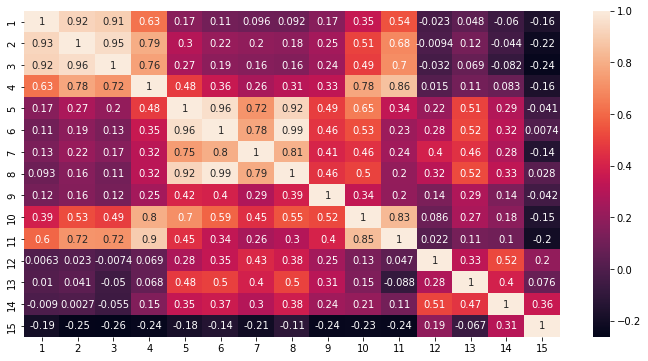

In [ ]:
# Asymmetric - ssim(A,B) != ssim(B,A) - Higher is more similiar (Max 1)
f,ax=plt.subplots(1,1,figsize=(12,6))
# mask = np.triu(np.ones_like(df_sim_ssim, dtype=bool))
sns.heatmap(df_sim_ssim,annot=True)


Based on the SSIM we can see that:

-- RGB (1,2,3) are **very similiar** (thus we can select only one of them)

-- Bands 5,6,8 are **very similiar**

-- Bands 4,10,11 are quite **similiar**

-- Bands 12,13,14,15,7 and 9 are **unique**


We need to test if taking only 5 "distinct" ones is sufficient e.g. 1,4,6,7,9
(5 instead of 11 bands)

(The MSE comparison below shows more or less the same results)

In [ ]:
for c in range(1,num_bands+1):
  ns=df_sim_ssim[c].nlargest(n=3).where(df_sim_ssim[c]>0.8)
  print('band {:2d},   most similiar bands: {}\t{}'.format(c,list(ns.index),ns.values))

band  1,   most similiar bands: [1, 2, 3]	[1.         0.92714188 0.91748332]
band  2,   most similiar bands: [2, 3, 1]	[1.         0.95565211 0.92351302]
band  3,   most similiar bands: [3, 2, 1]	[1.         0.95054778 0.90535661]
band  4,   most similiar bands: [4, 11, 10]	[1.         0.89531485 0.80238916]
band  5,   most similiar bands: [5, 6, 8]	[1.         0.95807315 0.92219384]
band  6,   most similiar bands: [6, 8, 5]	[1.         0.9875708  0.95840019]
band  7,   most similiar bands: [7, 8, 6]	[ 1. nan nan]
band  8,   most similiar bands: [8, 6, 5]	[1.         0.98736234 0.92164553]
band  9,   most similiar bands: [9, 10, 5]	[ 1. nan nan]
band 10,   most similiar bands: [10, 11, 4]	[1.         0.84627848        nan]
band 11,   most similiar bands: [11, 4, 10]	[1.         0.85881648 0.83373763]
band 12,   most similiar bands: [12, 14, 7]	[ 1. nan nan]
band 13,   most similiar bands: [13, 8, 6]	[ 1. nan nan]
band 14,   most similiar bands: [14, 12, 13]	[ 1. nan nan]
band 15,   mos

## MSE similiarity between the ALL bands (for feature selection)

To see which are the most distinct bands for feature selection

In [ ]:
#MSE - symmetric  - Lower is more similiar (Min 0)
df_sim_mse.corr()

1         2         3         4         5         6         7   \
1   1.000000  0.993461  0.995485  0.953512  0.765965  0.701493  0.675178   
2   0.993461  1.000000  0.999791  0.981678  0.834323  0.778236  0.754946   
3   0.995485  0.999791  1.000000  0.977733  0.823275  0.765686  0.741854   
4   0.953512  0.981678  0.977733  1.000000  0.924053  0.883601  0.866034   
5   0.765965  0.834323  0.823275  0.924053  1.000000  0.995485  0.991385   
6   0.701493  0.778236  0.765686  0.883601  0.995485  1.000000  0.999339   
7   0.675178  0.754946  0.741854  0.866034  0.991385  0.999339  1.000000   
8   0.670279  0.750583  0.737390  0.862703  0.990498  0.999079  0.999975   
9   0.665424  0.746267  0.733004  0.859406  0.989565  0.998759  0.999886   
10  0.830146  0.888361  0.879175  0.959571  0.994210  0.979580  0.971657   
11  0.932366  0.967527  0.962408  0.997938  0.946362  0.911444  0.895930   
12  0.398299  0.500239  0.482943  0.655902  0.894494  0.932804  0.945218   
13  0.846198  0.901198  0.892291  0.966795  0.989853  0.972409  0.963406   
14  0.749310  0.819559  0.807869  0.913103  0.998256  0.996017  0.992761   
15  0.301638  0.190859  0.210081  0.000328 -0.381729 -0.467677 -0.499420   

          8         9         10        11        12        13        14  \
1   0.670279  0.665424  0.830146  0.932366  0.398299  0.846198  0.749310   
2   0.750583  0.746267  0.888361  0.967527  0.500239  0.901198  0.819559   
3   0.737390  0.733004  0.879175  0.962408  0.482943  0.892291  0.807869   
4   0.862703  0.859406  0.959571  0.997938  0.655902  0.966795  0.913103   
5   0.990498  0.989565  0.994210  0.946362  0.894494  0.989853  0.998256   
6   0.999079  0.998759  0.979580  0.911444  0.932804  0.972409  0.996017   
7   0.999975  0.999886  0.971657  0.895930  0.945218  0.963406  0.992761   
8   1.000000  0.999957  0.970070  0.892966  0.947379  0.961668  0.992094   
9   0.999957  1.000000  0.968513  0.890075  0.949333  0.959714  0.991124   
10  0.970070  0.968513  1.000000  0.975520  0.841509  0.998366  0.989530   
11  0.892966  0.890075  0.975520  1.000000  0.702275  0.980478  0.936520   
12  0.947379  0.949333  0.841509  0.702275  1.000000  0.825339  0.905045   
13  0.961668  0.959714  0.998366  0.980478  0.825339  1.000000  0.986822   
14  0.992094  0.991124  0.989530  0.936520  0.905045  0.986822  1.000000   
15 -0.505147 -0.510837 -0.281144 -0.063334 -0.753679 -0.251005 -0.402815   

          15  
1   0.301638  
2   0.190859  
3   0.210081  
4   0.000328  
5  -0.381729  
6  -0.467677  
7  -0.499420  
8  -0.505147  
9  -0.510837  
10 -0.281144  
11 -0.063334  
12 -0.753679  
13 -0.251005  
14 -0.402815  
15  1.000000

In [ ]:
for c in range(1,num_bands+1):
  ns=df_sim_mse[c].nsmallest(n=3).where(df_sim_mse[c]<0.2)
  print('band {:2d},   most similiar bands: {}\t{}'.format(c,list(ns.index),ns.values))

band  1,   most similiar bands: [1, 3, 2]	[0.         0.00052242 0.00052836]
band  2,   most similiar bands: [2, 3, 1]	[0.         0.00010664 0.00052836]
band  3,   most similiar bands: [3, 2, 1]	[0.         0.00010664 0.00052242]
band  4,   most similiar bands: [4, 11, 2]	[0.         0.00078403 0.00169939]
band  5,   most similiar bands: [5, 6, 10]	[0.         0.0014777  0.00237138]
band  6,   most similiar bands: [6, 8, 7]	[0.         0.00040879 0.00074807]
band  7,   most similiar bands: [7, 8, 6]	[0.         0.00052553 0.00074807]
band  8,   most similiar bands: [8, 6, 7]	[0.         0.00040879 0.00052553]
band  9,   most similiar bands: [9, 8, 6]	[0.         0.00131437 0.00181976]
band 10,   most similiar bands: [10, 5, 11]	[0.         0.00237138 0.00358712]
band 11,   most similiar bands: [11, 4, 10]	[0.         0.00078403 0.00358712]
band 12,   most similiar bands: [12, 9, 8]	[0.         0.07225059 0.07256346]
band 13,   most similiar bands: [13, 14, 5]	[0.         0.00589963 0.

## Comparing each band and mask similiarity (on a specific sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


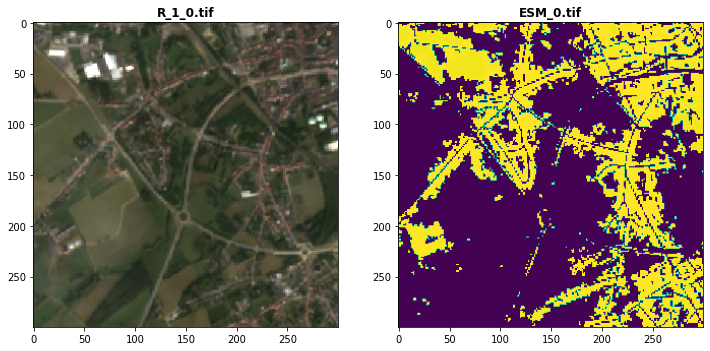

In [ ]:
f,axs=plt.subplots(1,2,figsize=(12,6))

s2_sample = display_image(new_img,title=new_img.name,ax=axs[0])
new_esm_sample = display_image(new_esm_mask,bands=[1],title=new_esm_mask.name,ax=axs[1])

Mask & Band=1	SSIM=0.03624923636222898
Mask & Band=2	SSIM=0.05112527134361696
Mask & Band=3	SSIM=0.046744304869476574
Mask & Band=4	SSIM=0.06974592383099433
Mask & Band=5	SSIM=0.10002115043619522
Mask & Band=6	SSIM=0.10166440091427964
Mask & Band=7	SSIM=0.11196211165457816
Mask & Band=8	SSIM=0.1048122514731617
Mask & Band=9	SSIM=0.12486056267448682
Mask & Band=10	SSIM=0.10607327828820855
Mask & Band=11	SSIM=0.07953482118091801
Mask & Band=12	SSIM=0.16907069219923135
Mask & Band=13	SSIM=0.07584716239169957
Mask & Band=14	SSIM=0.07039098572337685
Mask & Band=15	SSIM=-0.1446159594533556


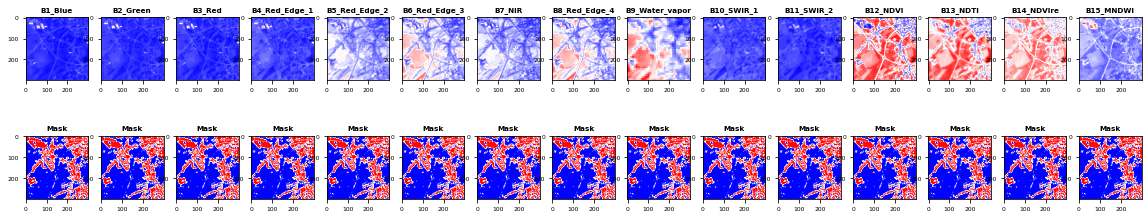

In [ ]:
SMALL_SIZE = 6
matplotlib.rc('font', size=SMALL_SIZE)

cms = ['bwr']
for cm in cms:
  f, axes = plt.subplots(2,num_bands,figsize=(20,4))
  for i in range(1,s2_sample.count+1):
    img = s2_sample.read(i)
    show(normalize(img), ax=axes[0,i-1], title=bands_dictionary[i].format(i),cmap=cm)
    # plt.suptitle(cm)
    msk=new_esm_sample.read(1)
    m,s = calc_similiarity(img,msk)
    print('Mask & Band={}\tSSIM={}'.format(i,s))
    show(msk, ax=axes[1,i-1], title='Mask',cmap=cm)
    
  plt.show()

# Segmenation Experiments - Initial Results

We are now in the early stages of experimentation with the Segmentation task, (using fastai UNET and Keras in parallel), here are a few examples of the original vs. predicted masks
(Of course these are just initial experiments, but it looks promising)

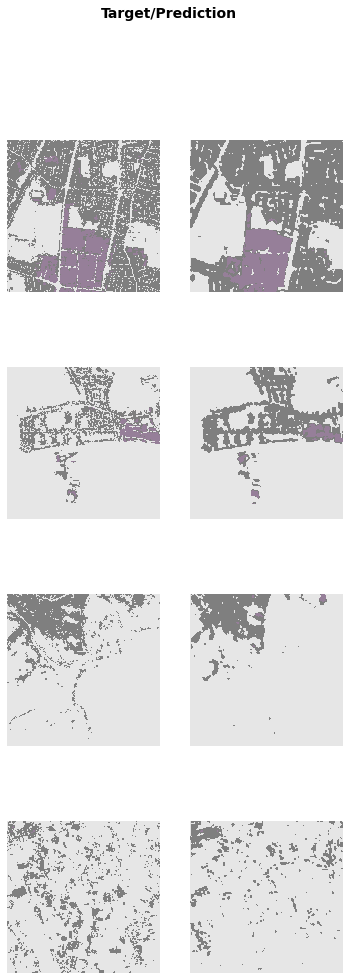

<br>

PLEASE NOTE the segmentation was moved to [another notebook](https://colab.research.google.com/drive/1Wg1Ng8qBYKuYuA9MpIdjYoYLFKwdWa8d?usp=sharing)

<br>

# Playground

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_1_70.tif' mode='r'>

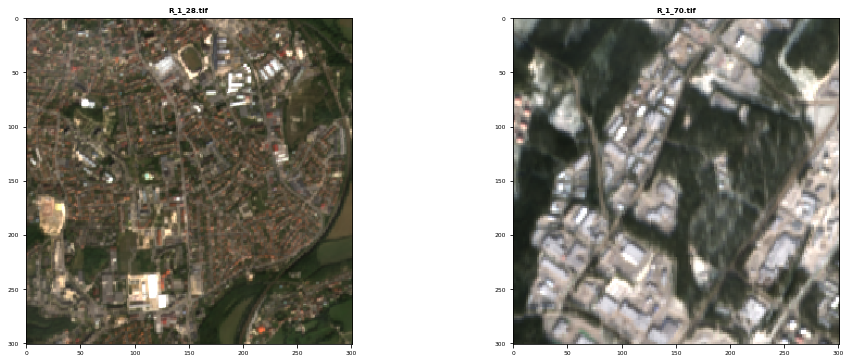

In [ ]:
imggg0 = Path(os.path.join(s2_path,'R_1_28.tif'))
imggg1 = Path(os.path.join(s2_path,'R_1_70.tif'))
f,ax = plt.subplots(1,2,figsize=(16,6))
display_image(imggg0,title=imggg0.name,ax=ax[0])
display_image(imggg1,title=imggg1.name,ax=ax[1])

In [ ]:
# l = glob.glob(S2_DIR + '/*.tif')
def get_fname(fff):
  return Path(fff).name

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

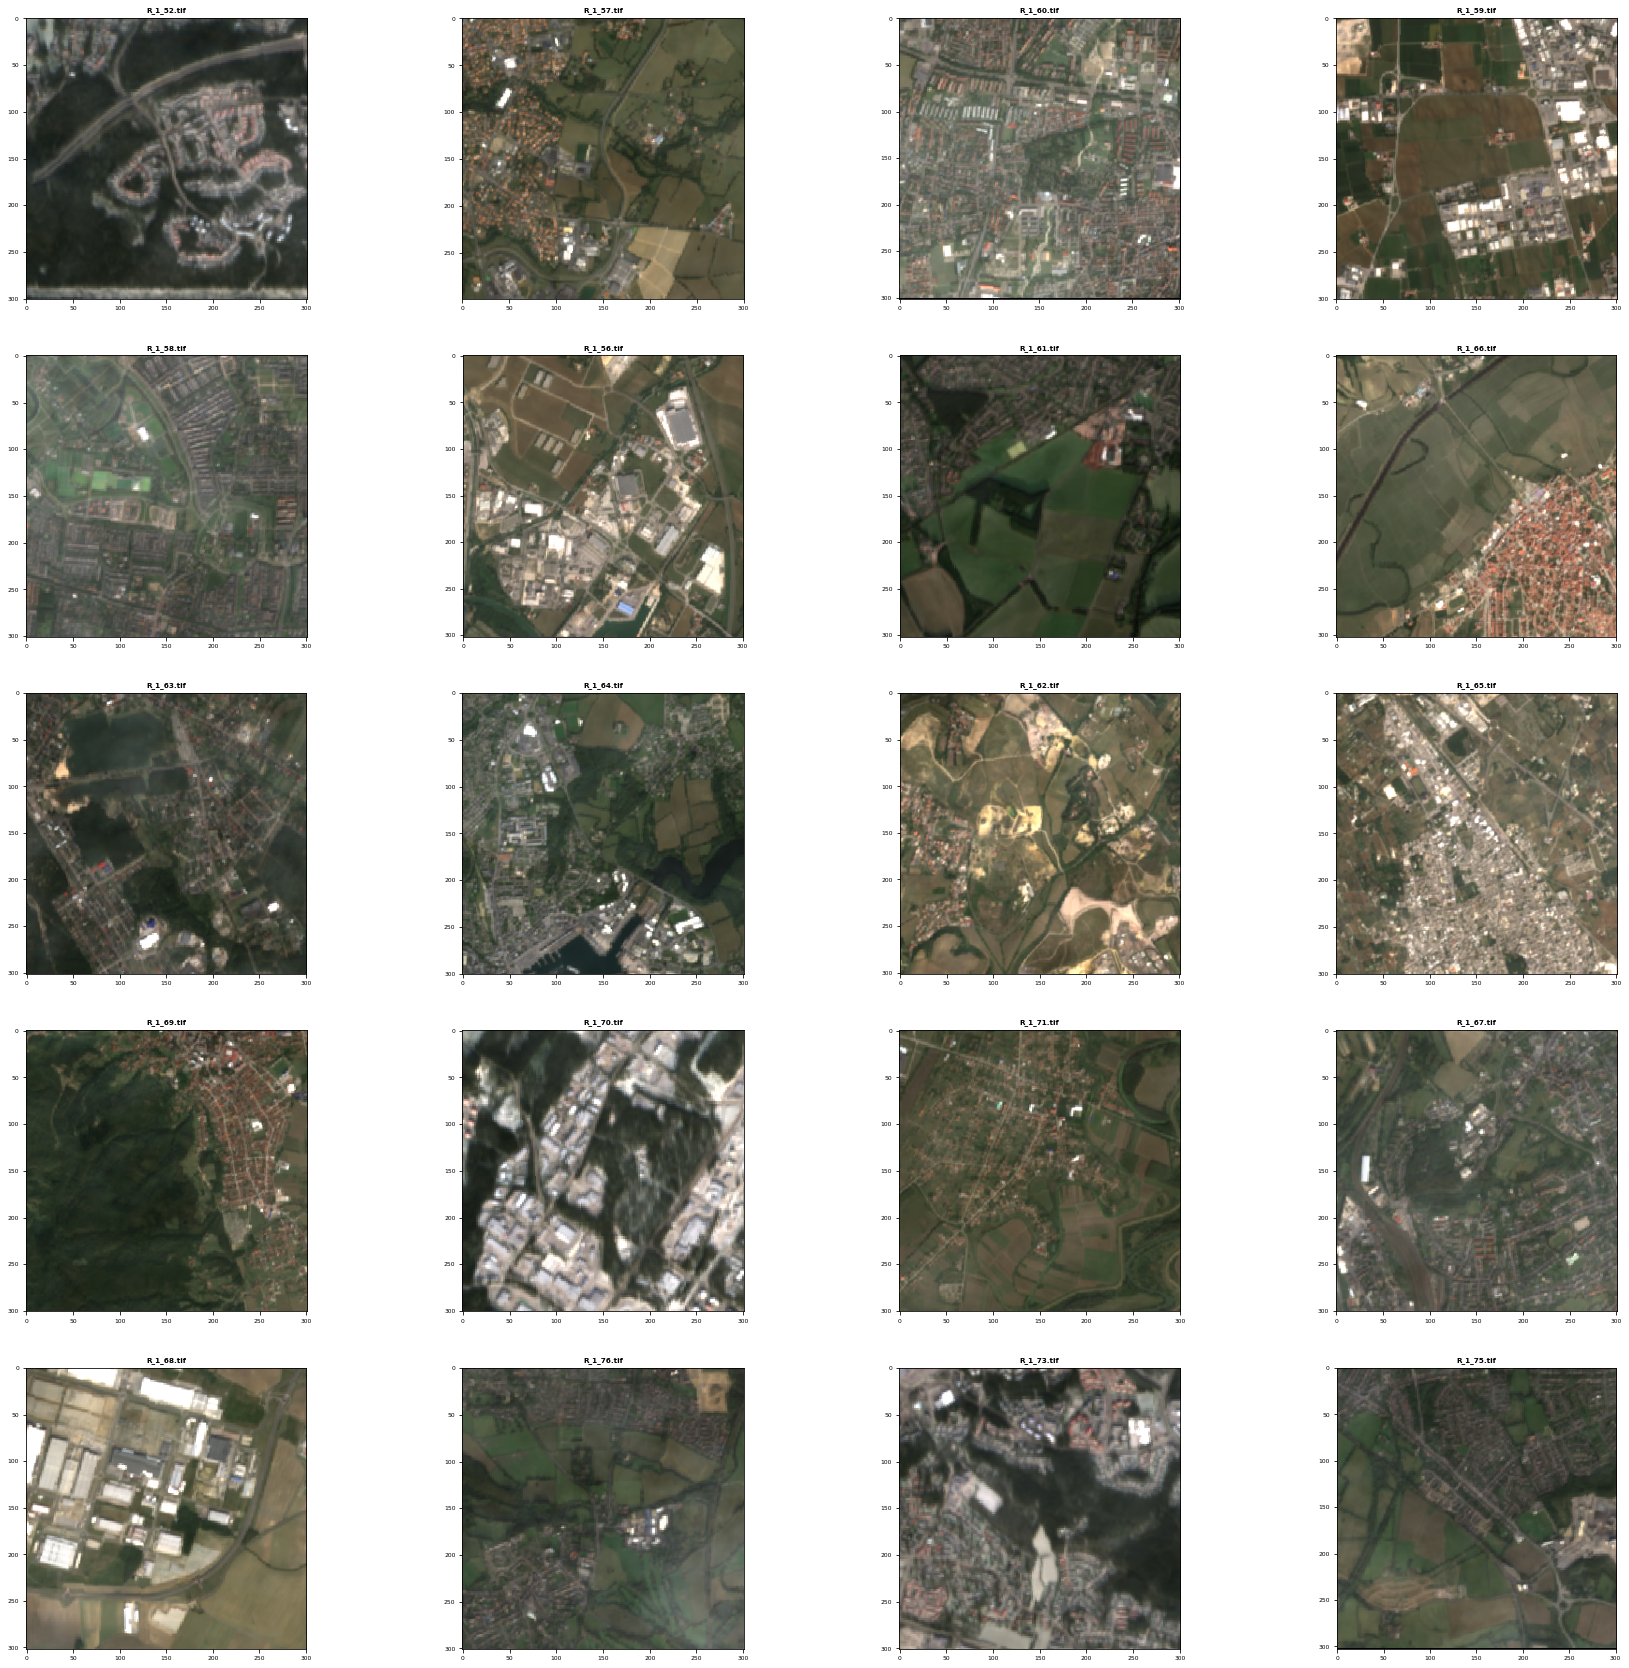

In [ ]:
f,ax = plt.subplots(5,4,figsize=(30,30))

files = glob.glob(S2_DIR + '/*.tif')[55:75]
k=0

for i in range(5):
  for j in range(4):
    display_image(files[k],title=get_fname(files[k]),ax=ax[i,j])
    k+=1